# Defining relevant functions


In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from scipy.stats import laplace, norm
from typing import Callable

In [2]:
def arbitrary_poly(params: list) -> Callable:
    """
    Takes the parameters in params and makes them into a polynomial 
        theta_0 + theta_1*x + theta_2*x^2 + ... + theta_n*x^n
    where n is model order and theta_0 is bias. 
    Args:
        params: list on format [theta_0, theta_1, theta_2, ..., theta_n]
    Returns:
        Function with single argument x. 
    """
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model


In [3]:
class GaussParams:
    def __init__(self, mean: float, std: float):
        self.mean = mean
        self.std = std
        self.var = std**2

        # aliases, these are the names used in scipy.stats functions
        self.loc = self.mean
        self.scale = self.std

    def __iter__(self):  # to allow tuple unpacking
        return iter((self.mean, self.std))


class LaplaceParams:
    def __init__(self, mean: float, beta: float):
        self.mean = mean
        self.beta = beta
        
        # aliases, these are the names used in scipy.stats functions
        self.loc = self.mean
        self.scale = self.beta

    def __iter__(self):  # to allow tuple unpacking
        return iter((self.mean, self.beta))


In [4]:
def generate_noise(
        N: int, 
        magnitude: float, 
        alpha: float, 
        gauss_params: GaussParams, 
        laplace_params: LaplaceParams, 
        seed: int = None
    ) -> np.ndarray:
    """
    Generate noise based on the mixture model: alpha * gaussian + (1 - alpha) * laplacian.
    Args:
        N: number of noise points to generate.
        magnitude: the noise amplitude/magnitude.
        alpha: probabilty of guassian or laplacian, should be in interval [0, 1].
        gauss_params: mean and std of gaussian distribution
        laplace_params: mean and beta of laplacian distribution
        seed: a custom seed to the RNG. If None, the RNG is not seeded.
    Returns:
        A list of N noise points.
    """
    if seed is not None:
        np.random.seed(seed)

    if alpha == 1:
        assert gauss_params is not None
        noise = np.random.normal(*gauss_params, N)
    elif alpha == 0:
        assert laplace_params is not None
        noise = np.random.laplace(*laplace_params, N)
    else:
        assert gauss_params is not None
        assert laplace_params is not None
        assert 0 < alpha < 1
        noise = np.zeros((N,))
        for i in range(N):
            r = np.random.uniform(0,1)
            if r <= alpha:
                noise[i] = np.random.normal(*gauss_params)
            else:
                noise[i] = np.random.laplace(*laplace_params)
    noise *= magnitude

    return noise

In [5]:
def add_outliers(y: np.ndarray, gamma: float, outlier_ampl: float = 100, seed: int = None) -> np.ndarray:
    """
    Adds outliers to y with probabilty gamma.
    Args:
        y: an array of measurement values with or without noise, shape = (N,) or (N,1).
        gamma: probability of a specific measurement being an outlier.
        outlier_ampl: amplitude of outlier, default 100.
        seed: custom seed to RNG. If None, do not reseed RNG.
    Returns:
        y_outlier: an array of the same lengths as y, but with some added outliers.
    """
    if seed is not None:
        np.random.seed(seed)

    assert 0 <= gamma <= 1

    N = y.shape[0]
    y_outlier = np.copy(y)
    for i in range(N):
        r = np.random.uniform(0,1)
        if r <= gamma:
            y_outlier[i] = outlier_ampl

    return y_outlier


In [6]:
def least_square(u: np.ndarray, y: np.ndarray, n_params: int) -> np.ndarray:
    """
    Uses least sqaure (LS) to make the best fitting list of parameters.
    Args:
        u: data x values, shape = (N_samples,)
        y: data y values, shape = (N_samples,)
        n_params: number of parameters to find
    """
    N = u.shape[0]
    
    # Create data tensor
    u_tensor = np.ones((N,1))
    for i in range(1, n_params):
        u_tensor = np.append(u_tensor, np.power(u.reshape((-1,1)), i), axis=1)

    # Solve for LS params
    u_dot_u = u_tensor.T @ u_tensor
    u_dot_y = u_tensor.T @ y
    # linalg.solve is more numerically stable than linalg.inv and is therefore preferred
    ls_params = np.linalg.solve(u_dot_u, u_dot_y)

    return ls_params


In [7]:
def sum_abs_deviation(u: np.ndarray, y: np.ndarray, est_params: np.ndarray) -> float:
    """
    Calculate the sub of absolute deviation between outputs y for each u.
    Args:
        u: data points x value.
        y: measurement data.
        est_params: estimate parameters from the data.
    Returns:
        sad: the sum of absolute deviation.
    """
    assert len(u) == len(y)

    y_est = arbitrary_poly(est_params)(u)
    sad = np.sum(np.abs(y - y_est))

    return sad

In [8]:
def log_likelihood(params: np.ndarray, u: np.ndarray, y: np.ndarray, pdf: Callable) -> np.float:
    """
    Computes the log-likelihood of the pdf given the data u and y.
    Args:
        params: the parameters for the model.
        u: data points x value.
        y: measurement data.
        pdf: pdf function from scipy of desired distribution.
    Returns:
        The log-likelihood of the pdf evaluated at the data, or np.inf.
    """
    if params[-1] < 0: 
        # standard deviation is estimated and cannot be negative
        return np.inf
    
    lik = pdf(y, loc=arbitrary_poly(params[:-1])(u), scale=params[-1])
    
    # log(0) = -inf
    if np.all(lik == 0):
        return np.inf

    ll = -np.sum(np.log(lik[np.nonzero(lik)]))
    return ll


def maximum_likelihood(u: np.ndarray, y: np.ndarray, n_params: int, pdf: Callable) -> np.ndarray:
    """
    Calculates the Maximum Likelihood estimate for a polynomial model with n_params parameters
    based on the given pdf.
    Args:
        u: data points x values, shape = (N,).
        y: measurement data, shape = (N,).
        n_params: the number of parameters in the model, including bias. 
                  theta_0 + theta_1*x + theta_2*x^2 + ... + theta_n*x^n
        pdf: pdf function from scipy of desired distribution.
    Returns:
        List of parameters. 
    """
    assert len(u) == len(y)
    
    N = u.shape[0]
    init_guess = np.zeros((n_params + 1,))
    init_guess[-1] = N

    optres = optimize.minimize(
        fun=log_likelihood, x0=init_guess, args=(u, y, pdf), options={"disp": True}
    )

    ml_params = optres.x[:-1]
    return ml_params


In [9]:
def RSS(u: np.ndarray, y: np.ndarray, est_params: np.ndarray) -> float:
    """
    Calculate Residual Sum of Sqaures.
    """
    assert len(u) == len(y)
    y_est = arbitrary_poly(est_params)(u)
    rss = np.sum((y - y_est)**2)
    return rss


def RMSE(u: np.ndarray, y: np.ndarray, est_params: np.ndarray) -> float:
    """
    Calculate Root Mean Square Error.
    """
    assert len(u) == len(y)
    N = u.shape[0]
    rmse = RSS(u, y, est_params) / N
    return rmse


def MAD(u: np.ndarray, y: np.ndarray, est_params: np.ndarray) -> float:
    """
    Calculate Mean Absolute Deviation.
    """
    # TODO: This is actually done ExpectedValue(abs(y-y_est)) which depends 
    # on the distribution. The way done below assumes centered and unskewed 
    # distribution (Gaussian, Laplacian, etc). How to do generally? 
    assert len(u) == len(y)
    y_est = arbitrary_poly(est_params)(u)
    N = u.shape[0]
    mad = np.sum(np.abs(y - y_est)) / N
    return mad


def FVU(u: np.ndarray, y: np.ndarray, est_params: np.ndarray) -> float:
    """
    Calculate Fraction of Variance Unexplained.
    """
    assert len(u) == len(y)
    rss = RSS(u, y, est_params)
    var = np.var(y)
    fvu = rss / var
    return fvu


def Rsquare(u: np.ndarray, y: np.ndarray, est_params: np.ndarray) -> float:
    """
    Calculate R^2.
    """
    r2 = 1 - FVU(u, y, est_params)
    return r2


def FIT(u: np.ndarray, y: np.ndarray, est_params: np.ndarray) -> float:
    """
    Calculate Fit. 
    """
    root_rss = np.sqrt(RSS(u, y, est_params))
    root_var = np.sqrt(np.var(y))
    fit = 100 * (1 - root_rss / root_var)
    return fit


# Generate data and train models

## Generate data

In [10]:
# True model
true_params = [1,-8,4]
n_params = len(true_params)
y_model = arbitrary_poly(true_params)

# Hyperparameters for noise generation
magnitude = 1.2  # noise magnitude
N = 10          # number of samples

# Setup RNG
np.random.seed(0)  # Non-random generation between code executions. Comment out for true random

# Generate data points
range_low = -1
range_high = 1

do_sorting = False
if do_sorting:
    u = np.sort(np.random.uniform(range_low, range_high, N))
else:
    u = np.random.uniform(range_low, range_high, N)

u_sorted = np.sort(u)  # only used for plotting
y_true = y_model(u)

# Generate noise
noise = generate_noise(N, magnitude, 0, None, LaplaceParams(0, 1), seed=None)
y_noise = y_true + noise

# Add outliers
gamma = 0.3
y_outlier = add_outliers(y_noise, gamma)

# Split into train, test and validate sets
M = N // 2  # size of each subset
u_train, y_train = u[0:M], y_outlier[0:M]
u_test, y_test = u[M:2*M], y_outlier[M:2*M]
u_val, y_val = u[2*M:3*M], y_outlier[2*M:3*M]

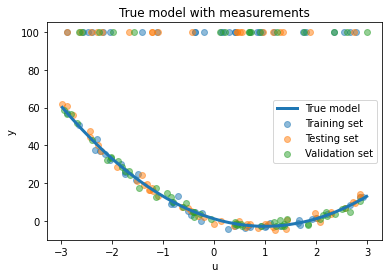

In [11]:
# Plot model and measurements
plt.figure()
plt.plot(u_sorted, y_model(u_sorted), lw=3, label="True model")
# plt.scatter(u, y_outlier, alpha=0.5, label="Measurements w/ outliers")
plt.scatter(u_train, y_train, alpha=0.5, label="Training set")
plt.scatter(u_test, y_test, alpha=0.5, label="Testing set")
plt.scatter(u_val, y_val, alpha=0.5, label="Validation set")
plt.legend()
plt.xlabel("u")
plt.ylabel("y")
plt.title("True model with measurements")
plt.show()


## Affine/linear model

In [12]:
# LS
affine_ls = least_square(u_train, y_train, 2)
affine_ls_mod = arbitrary_poly(affine_ls)
print(affine_ls)

# LS performance
sad_affine_ls = sum_abs_deviation(u_test, y_test, affine_ls)
print(sad_affine_ls)

# ML
affine_ml = maximum_likelihood(u, y_outlier, 2, pdf=laplace.pdf)
affine_ml_mod = arbitrary_poly(affine_ml)
print(affine_ml)

# ML performance
sad_affine_ml = sum_abs_deviation(u_test, y_test, affine_ml)
print(sad_affine_ml)



[47.49414121 -3.63409453]
2667.6882781654676
         Current function value: 1043.714458
         Iterations: 19
         Function evaluations: 403
         Gradient evaluations: 98
[18.56707448 -7.43724477]
2142.0586815409065


## Quadratic model

In [13]:
# LS
quadratic_ls = least_square(u_train, y_train, 3)
quadratic_ls_mod = arbitrary_poly(quadratic_ls)
print(quadratic_ls)

# LS performance
sad_quadratic_ls = sum_abs_deviation(u_test, y_test, quadratic_ls)
print(sad_quadratic_ls)

# ML
quadratic_ml = maximum_likelihood(u, y_outlier, 3, pdf=laplace.pdf)
quadratic_ml_mod = arbitrary_poly(quadratic_ml)
print(quadratic_ml)

# ML performance
sad_quadratic_ml = sum_abs_deviation(u_test, y_test, quadratic_ml)
print(sad_quadratic_ml)



[40.41444402 -3.44997367  2.54890983]
2676.5141760540514
         Current function value: 1010.095583
         Iterations: 34
         Function evaluations: 737
         Gradient evaluations: 145
[ 1.21896007 -8.11739188  4.16358178]
1749.9825505379251


## Cubic model

In [14]:
# LS
cubic_ls = least_square(u_train, y_train, 4)
cubic_ls_mod = arbitrary_poly(cubic_ls)
print(cubic_ls)

# LS perforamnce
sad_cubic_ls = sum_abs_deviation(u_test, y_test, cubic_ls)
print(sad_cubic_ls)

# ML
cubic_ml = maximum_likelihood(u, y_outlier, 4, pdf=laplace.pdf)
cubic_ml_mod = arbitrary_poly(cubic_ml)
print(cubic_ml)

# ML performance
sad_cubic_ml = sum_abs_deviation(u_test, y_test, cubic_ml)
print(sad_cubic_ml)



[39.75329367  1.12662614  2.72963459 -0.85666068]
2654.6200560891466
         Current function value: 1009.990184
         Iterations: 38
         Function evaluations: 1145
         Gradient evaluations: 188
[ 1.15755061 -7.46744254  4.1870851  -0.09932694]
1746.1685547824688


## Plot resulting models


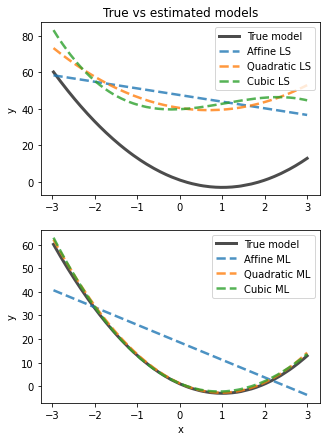

In [15]:
plt.subplots(sharex=True, figsize=(5,7))
plt.subplot(211)
plt.plot(u_sorted, y_model(u_sorted), "k-", lw=3, alpha=0.7, label="True model")
# plt.scatter(u_train, y_train, alpha=0.5, s=20, label="Training set")
# plt.scatter(u_test, y_test, alpha=0.5, s=20, label="Testing set")
# plt.scatter(u_val, y_val, alpha=0.5, s=20, label="Validation set")

plt.plot(u_sorted, affine_ls_mod(u_sorted), "--", lw=2.5, alpha=0.8, label="Affine LS")
plt.plot(u_sorted, quadratic_ls_mod(u_sorted), "--", lw=2.5, alpha=0.8, label="Quadratic LS")
plt.plot(u_sorted, cubic_ls_mod(u_sorted), "--", lw=2.5, alpha=0.8, label="Cubic LS")

plt.legend()
plt.title("True vs estimated models")
plt.ylabel("y")

plt.subplot(212)
plt.plot(u_sorted, y_model(u_sorted), "k-", lw=3, alpha=0.7, label="True model")
plt.plot(u_sorted, affine_ml_mod(u_sorted), "--", lw=2.5, alpha=0.8, label="Affine ML")
plt.plot(u_sorted, quadratic_ml_mod(u_sorted), "--", lw=2.5, alpha=0.8, label="Quadratic ML")
plt.plot(u_sorted, cubic_ml_mod(u_sorted), "--", lw=2.5, alpha=0.8, label="Cubic ML")

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
